In [26]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

In [86]:
currTime = strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
NAME = f"test-tensorboard-{ currTime }"
print(NAME)

tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

test-tensorboard-10-03-2019-16-54-44


In [118]:
def showHsv(img):    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

(1008, 1600, 3)
image with its value untouched, but saturation and hue randomized:


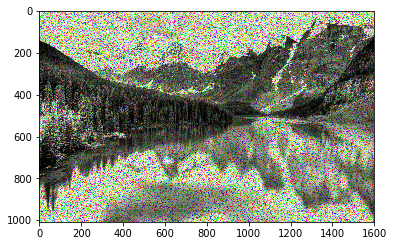

In [121]:
img_in = cv2.imread('pic.jpg')
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
print('image with its value untouched, but saturation and hue randomized:')
showHsv(hsv)





In [ ]:
for i in range(3):
    pic = hsv[:,:,i]
    plt.imshow(pic, cmap='gray')
    plt.show()

In [41]:
sess = tf.Session()


(10000, 2)
(10000,) (10000,)
(10000, 2)


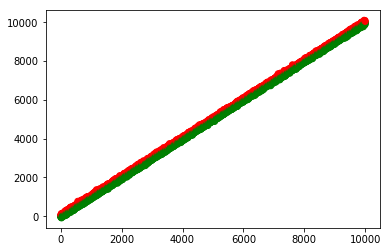

[[1 0]
 [0 1]
 [0 1]
 ...
 [0 1]
 [0 1]
 [1 0]]


In [114]:
n = 10000
X = np.arange(n).reshape(n,1)
X = np.hstack((np.ones(n).reshape(n,1), X))
print(X.shape)
y = np.random.randn(n)*50 + X[:, 1]
#y = y.reshape(n,1)
print(y.shape, X[:,1].shape)
#print(y)
#plt.plot(X[:,1], y)
yval = y
# labels: 1 if above line, 0  below
y = y > X[:,1]
y = y.reshape(n,1)
y = np.hstack((y, ~y )).astype('uint8')
print(y.shape)
colors = ['red' if i  else 'green' for i in y[:,0]]
plt.scatter(X[:,1], yval, color=colors)
plt.show()
print(y)

In [119]:
model = Sequential()
model.add(Dense(2))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
             metrics=['accuracy'])

In [120]:
model.fit(X, y, batch_size=32, epochs=6, validation_split=0.2, callbacks=[tensorboard])

Train on 8000 samples, validate on 2000 samples
Epoch 1/6
8000/8000 [==============================] - 1s 110us/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6930 - val_acc: 0.5090
Epoch 2/6
8000/8000 [==============================] - 1s 80us/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.5090
Epoch 3/6
8000/8000 [==============================] - 1s 81us/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.5090
Epoch 4/6
8000/8000 [==============================] - 1s 80us/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.5090
Epoch 5/6
8000/8000 [==============================] - 1s 79us/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.5090
Epoch 6/6
8000/8000 [==============================] - 1s 81us/step - loss: 0.6931 - acc: 0.5051 - val_loss: 0.6930 - val_acc: 0.5090


In [121]:
model.predict(X)

array([[0.50501955, 0.49498045],
       [0.50501955, 0.49498045],
       [0.50501955, 0.49498045],
       ...,
       [0.50501955, 0.49498045],
       [0.50501955, 0.49498045],
       [0.50501955, 0.49498045]], dtype=float32)